In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

# Load datasets with empty strings treated as NaN
df_climate = pd.read_csv('../data/climate_scores.csv', na_values=[''])
df_cost = pd.read_csv('../data/cost_of_life_capitals.csv', na_values=[''])
df_coworking = pd.read_csv('../data/coworking_capitals.csv', na_values=[''])
df_death = pd.read_csv('../data/death_per_capital_2023.csv', na_values=[''])
df_internet = pd.read_csv('../data/internet_quality_capitals.csv', na_values=[''])
df_ips = pd.read_csv('../data/ips_capitals.csv', na_values=[''])

# Standardize city names
for df in [df_climate, df_cost, df_coworking, df_death, df_internet, df_ips]:
    if 'City' in df.columns:
        df['City'] = df['City'].str.strip()
    elif 'capital' in df.columns:
        df['capital'] = df['capital'].str.strip()
    elif 'Capital' in df.columns:
        df['Capital'] = df['Capital'].str.strip()

# Merge all datasets on 'City'
df_merged = (
    df_cost.merge(df_climate, on='City', how='left')
    .merge(df_internet.rename(columns={'city': 'City'}), on='City', how='left')
    .merge(df_coworking.rename(columns={'capital': 'City'}), on='City', how='left')
    .merge(df_death.rename(columns={'Capital': 'City'}), on='City', how='left')
    .merge(df_ips.rename(columns={'Município': 'City'}), on='City', how='left')
)

# Drop duplicates
df_merged.drop_duplicates(subset=['City'], keep='first', inplace=True)

# Define relevant columns for scoring
key_columns = [
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)',
    'Public Transport (Monthly)', 'Índice de Progresso Social',
    'Moradia', 'Saúde e Bem-estar', 'Água e Saneamento',
    'Nutrição e Cuidados Médicos Básicos', 'speed_mbps',
    'Segurança Pessoal', 'Taxa_2023', 'Climate Score'
]

# Filter out rows with too many missing values
df_filtered = df_merged.dropna(subset=key_columns, how='all')

# Normalize the data using Min-Max Scaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_filtered[key_columns])
df_normalized = pd.DataFrame(scaled_data, columns=key_columns)
df_normalized.insert(0, 'City', df_filtered['City'])

# Invert negative metrics (lower values are better)
negative_metrics = [
    '1BR Apartment (Center)', '1BR Apartment (Outside)',
    'Utilities (Monthly)', 'Internet (Monthly)', 'Groceries (Monthly)',
    'Public Transport (Monthly)', 'Taxa_2023'
]

for col in negative_metrics:
    df_normalized[col] = 1 - df_normalized[col]

# Define category weights
category_weights = {
    'Quality of Life': 0.35,
    'Cost of Living': 0.20,
    'Infrastructure': 0.15,
    'Safety': 0.15,
    'Climate': 0.10,
    'Deaths': 0.05
}

# Define feature weights within each category
feature_weights = {
    # Cost of Living
    '1BR Apartment (Center)': ('Cost of Living', -0.15),
    '1BR Apartment (Outside)': ('Cost of Living', -0.10),
    'Utilities (Monthly)': ('Cost of Living', -0.25),
    'Internet (Monthly)': ('Cost of Living', -0.25),
    'Groceries (Monthly)': ('Cost of Living', -0.20),

    # Quality of Life
    'Índice de Progresso Social': ('Quality of Life', 0.20),
    'Moradia': ('Quality of Life', 0.15),
    'Saúde e Bem-estar': ('Quality of Life', 0.30),
    'Água e Saneamento': ('Quality of Life', 0.25),
    'Nutrição e Cuidados Médicos Básicos': ('Quality of Life', 0.10),

    # Infrastructure
    'speed_mbps': ('Infrastructure', 1.00),

    # Safety
    'Segurança Pessoal': ('Safety', 1.00),

    # Death per capita
    'Taxa_2023': ('Deaths', -1.00),

    # Climate
    'Climate Score': ('Climate', 1.00)
}

# Group features by category and compute final weights
category_features = defaultdict(list)
for feature, (category, weight) in feature_weights.items():
    category_features[category].append((feature, weight))

final_weights = {}
for category, features in category_features.items():
    total_category_weight = sum(w for _, w in features)
    category_share = category_weights[category]
    for feature, weight in features:
        final_weights[feature] = (weight / total_category_weight) * category_share

# Calculate Remote Work Score
def calculate_score(row):
    return sum(row[col] * final_weights[col] for col in final_weights if col in row and pd.notna(row[col]))

df_normalized['Remote Work Score'] = df_normalized.apply(calculate_score, axis=1)

# Sort by Remote Work Score
df_ranked = df_normalized.sort_values(by='Remote Work Score', ascending=False).reset_index(drop=True)

# Save and display top 20 cities
print(df_ranked[['City', 'Remote Work Score']].head(20))
df_ranked.to_csv("ranked_analysis.csv", index=False, encoding="utf-8")

              City  Remote Work Score
0          Goiânia           0.781818
1           Cuiabá           0.755800
2    Florianópolis           0.745239
3         Brasília           0.715970
4   Belo Horizonte           0.699045
5           Palmas           0.658766
6         Curitiba           0.654562
7     Campo Grande           0.632318
8        São Paulo           0.614381
9     Porto Alegre           0.596970
10         Vitória           0.580395
11       Boa Vista           0.569220
12     João Pessoa           0.555591
13        Teresina           0.547985
14           Belém           0.541502
15         Aracaju           0.541169
16       Fortaleza           0.491283
17          Manaus           0.488968
18           Natal           0.476591
19  Rio de Janeiro           0.473973


## Top 10 Capitals

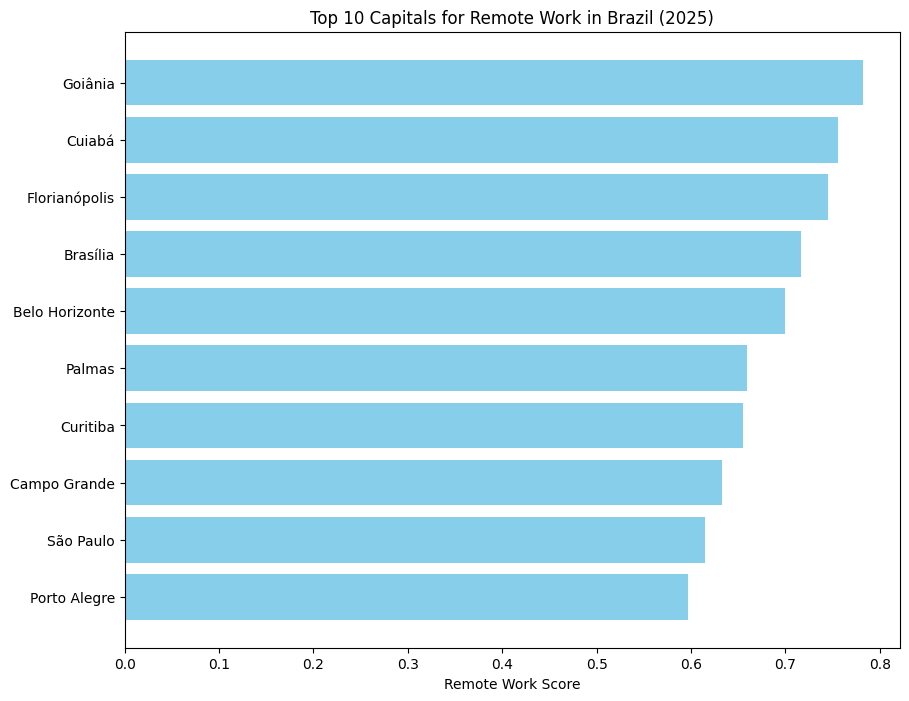

In [16]:
import matplotlib.pyplot as plt

top_10 = df_ranked.head(10)
plt.figure(figsize=(10, 8))
plt.barh(top_10['City'], top_10['Remote Work Score'], color='skyblue')
plt.xlabel('Remote Work Score')
plt.title('Top 10 Capitals for Remote Work in Brazil (2025)')
plt.gca().invert_yaxis()  # Show best at the top
plt.show()

## Comparison between Top 5

In [24]:
# Create a new DataFrame with the 5 categories
df_radar = df_ranked[['City']].copy()

# Compute composite metrics
df_radar['Cost of Living'] = (
    df_ranked['1BR Apartment (Center)'] * 0.4 +
    df_ranked['Utilities (Monthly)'] * 0.3 +
    df_ranked['Groceries (Monthly)'] * 0.3
)

df_radar['Internet Speed'] = df_ranked['speed_mbps']

df_radar['Climate'] = df_ranked['Climate Score']

df_radar['Safety'] = df_ranked['Segurança Pessoal']

df_radar['Quality of Life'] = (
    df_ranked['Índice de Progresso Social'] * 0.3 +
    df_ranked['Saúde e Bem-estar'] * 0.3 +
    df_ranked['Moradia'] * 0.2 +
    df_ranked['Água e Saneamento'] * 0.2
)

top_cities = df_ranked.head(5)['City'].tolist()
df_top5 = df_radar[df_radar['City'].isin(top_cities)].set_index('City')

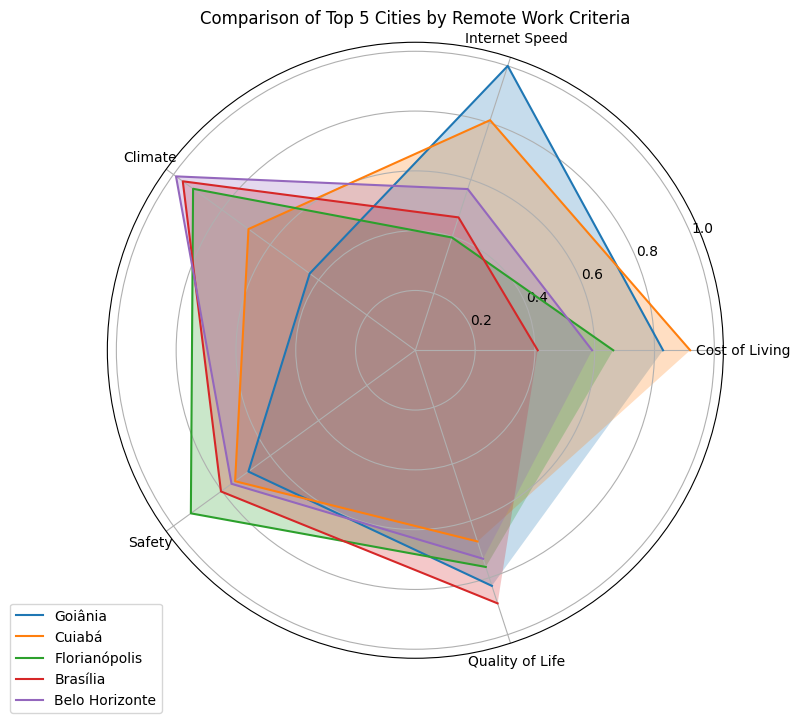

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar_chart(df, cities):
    labels = ['Cost of Living', 'Internet Speed', 'Climate', 'Safety', 'Quality of Life']
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for city in cities:
        stats = df.loc[city].values
        ax.plot(angles, stats, label=city)
        ax.fill(angles, stats, alpha=0.25)
        
    ax.set_xticks(angles)
    ax.set_xticklabels(labels)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Comparison of Top 5 Cities by Remote Work Criteria')
    plt.show()

plot_radar_chart(df_top5, top_cities)

C:\Users\samue\AppData\Local\Temp\ipykernel_14960\2271494809.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Remote Work Score', y='City', data=df_ranked.head(5), palette='viridis')


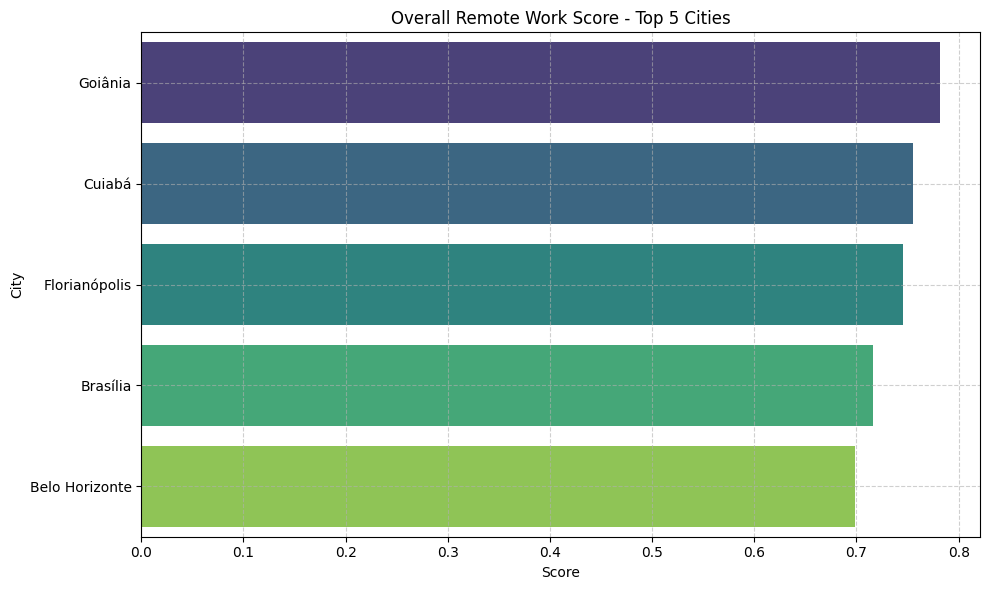

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(x='Remote Work Score', y='City', data=df_ranked.head(5), palette='viridis')
plt.title('Overall Remote Work Score - Top 5 Cities')
plt.xlabel('Score')
plt.ylabel('City')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('top_5_score.png', dpi=300)
plt.show()

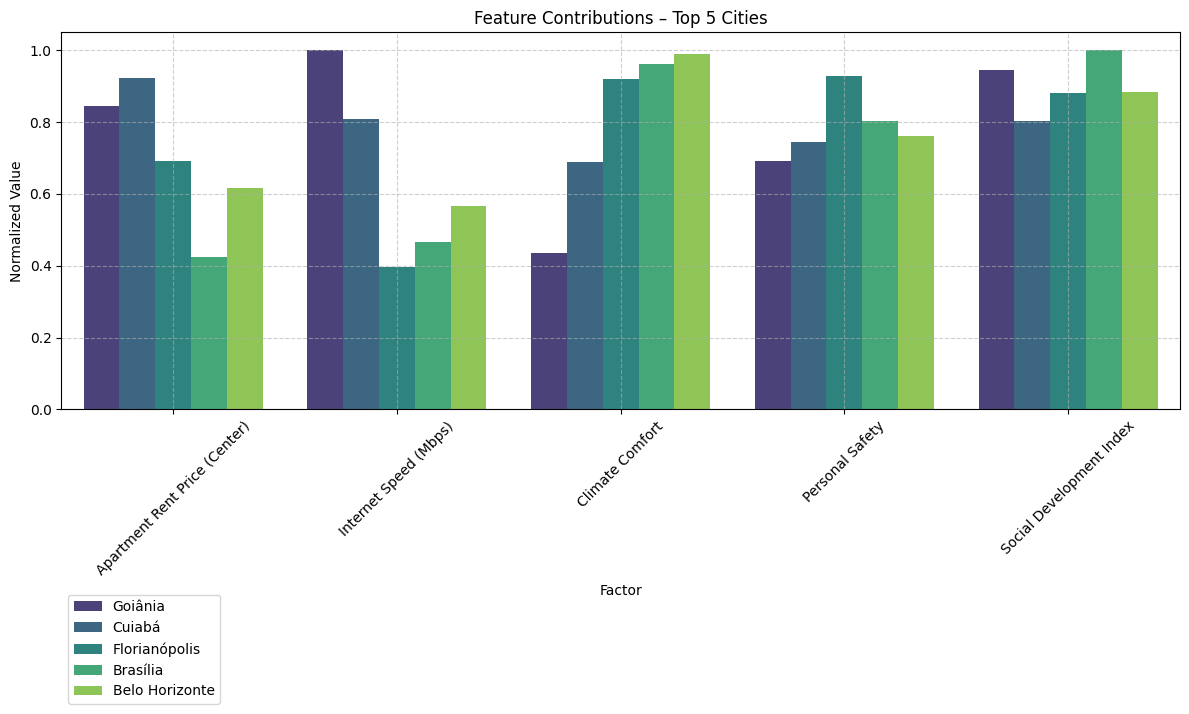

In [38]:
# Define important metrics with better labels
important_metrics = [
    '1BR Apartment (Center)', 'speed_mbps', 
    'Climate Score', 'Segurança Pessoal', 'Índice de Progresso Social'
]

# Rename columns for readability
metric_labels = {
    '1BR Apartment (Center)': 'Apartment Rent Price (Center)',
    'speed_mbps': 'Internet Speed (Mbps)',
    'Climate Score': 'Climate Comfort',
    'Segurança Pessoal': 'Personal Safety',
    'Índice de Progresso Social': 'Social Development Index'
}

# Prepare data for visualization
pivot_df = df_ranked[df_ranked['City'].isin(top_cities)][['City'] + important_metrics]
pivot_df = pivot_df.melt(id_vars='City', var_name='Metric', value_name='Value')

# Apply metric labels
pivot_df['Metric'] = pivot_df['Metric'].replace(metric_labels)

# Plot stacked bar chart
plt.figure(figsize=(12, 11))

sns.barplot(x='Metric', y='Value', hue='City', data=pivot_df, palette='viridis')

# Move legend to bottom left
plt.legend(loc='lower left', bbox_to_anchor=(0.0, -0.8), ncol=1)

plt.title('Feature Contributions – Top 5 Cities')
plt.ylabel('Normalized Value')
plt.xlabel('Factor')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
import folium
from folium.plugins import MarkerCluster

# Sample top 5 cities from df_ranked
top_cities = ["Goiânia", "Cuiabá", "Florianópolis", "Brasília", "Belo Horizonte"]

# Filter only the top 5 cities
df_top5 = df_ranked[df_ranked['City'].isin(top_cities)]

# Define city coordinates
city_coords = {
    "Goiânia": (-16.6867, -49.2649),
    "Cuiabá": (-15.6078, -56.0946),
    "Florianópolis": (-27.5942, -48.5486),
    "Brasília": (-15.7942, -47.8826),
    "Belo Horizonte": (-19.9167, -43.9345)
}

# Create base map centered around Brazil
brazil_map = folium.Map(location=[-15.7942, -47.8826], zoom_start=4)

# Add marker cluster to handle multiple markers
marker_cluster = MarkerCluster().add_to(brazil_map)

# Add markers for each city
for city in top_cities:
    if city in city_coords:
        lat, lon = city_coords[city]
        score = df_top5[df_top5['City'] == city]['Remote Work Score'].values[0]

        # Set marker color based on score
        if score > 90:
            color = 'green'
        elif score > 80:
            color = 'blue'
        else:
            color = 'red'

        folium.Marker(
            location=[lat, lon],
            popup=f"{city}: {score:.2f}",
            icon=folium.Icon(color=color)
        ).add_to(marker_cluster)

# Save as HTML file
brazil_map.save("remote_work_top5_map.html")

# Show in Jupyter Notebook or browser
print("Map saved as 'remote_work_top5_map.html'. Open it in a browser to view.")

Map saved as 'remote_work_top5_map.html'. Open it in a browser to view.
